In [ ]:
import pandas as pd
import os

def load_data(base_path):
    times_of_day = ['morning', 'afternoon', 'night']
    all_data = []

    for time in times_of_day:
        path = os.path.join(base_path, time)
        for file in os.listdir(path):
            full_path = os.path.join(path, file)
            if file.endswith('.csv'):
                df = pd.read_csv(full_path)
                df['Time of Day'] = time  
                df['Restaurant'] = file.replace('_menu.csv', '').replace('.csv', '')  
                all_data.append(df)

    return pd.concat(all_data, ignore_index=True)


In [ ]:
def clean_data(df):
    #Remove unwanted item 
    df = df[~df['Item Name'].str.contains("delivery fee", na=False)]
    df = df[~df['Item Name'].str.match(r"\d+ .* St, .*", na=False)]  

    
    df['Price'] = df['Price'].str.replace('$', '').str.strip()
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

    df = df.dropna(subset=['Price'])
    
    return df


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#Price distribution across different times of day - visualization
def plot_price_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Time of Day', y='Price', data=df)
    plt.title('Price Distribution Across Different Times of Day')
    plt.show()

#Comparison of Average price 
def average_price_comparison(df):
    print(df.groupby(['Restaurant', 'Time of Day'])['Price'].mean().unstack())

#Analysis of Menu diversity 
def menu_item_analysis(df):
    times = df['Time of Day'].unique()
    item_sets = {time: set(df[df['Time of Day'] == time]['Item Name']) for time in times}
    common_items = set.intersection(*item_sets.values())
    unique_items = {time: items - common_items for time, items in item_sets.items()}
    
    print("Common items across times:", common_items)
    for time, items in unique_items.items():
        print(f"Unique items in {time}:", items)


C:\Users\Celine John Philip\AppData\Local\Temp\ipykernel_9840\2091409839.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Price'] = df['Price'].str.replace('$', '').str.strip()


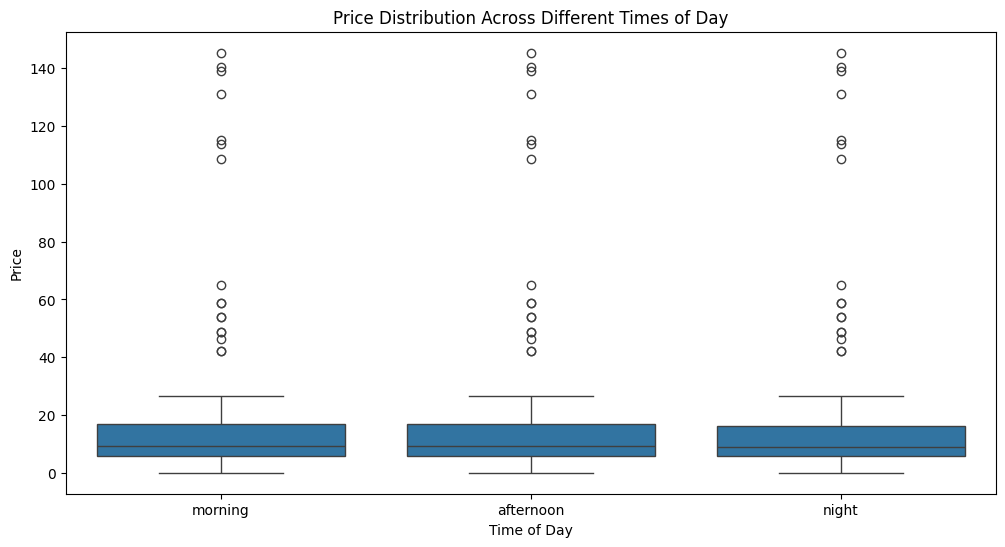

Time of Day              afternoon    morning      night
Restaurant                                              
ihop                     16.261497  16.261497  16.100539
ike's_love_&_sandwiches  14.756522  14.756522  14.745620
jack's_urban_eats        14.345190  14.220000  14.253038
jack_in_the_box           9.508647   9.601308   9.233267
mcdonald's                9.651538   8.006667   9.936154
mountain_mike's_pizza    10.644898  10.275455  10.644898
panda_express             5.867544   5.867544   5.867544
shake_shack              21.615352  21.508310  22.068261
starbucks                 6.145349   6.145349   6.102907
taco_bell                 7.829231   7.829231   7.266154


In [ ]:
base_path = 'D:\\uber eats\\different_time_menus'
data = load_data(base_path)
data = load_data(base_path)
cleaned_data = clean_data(data)

plot_price_distribution(cleaned_data)
average_price_comparison(cleaned_data)


In [ ]:
#Descriptive statistics of data
def descriptive_statistics(df):
    stats = df.groupby(['Restaurant', 'Time of Day'])['Price'].describe()
    print(stats)

descriptive_statistics(cleaned_data)


                                     count       mean        std   min  \
Restaurant              Time of Day                                      
ihop                    afternoon    167.0  16.261497   9.954849  0.00   
                        morning      167.0  16.261497   9.954849  0.00   
                        night        167.0  16.100539   9.900925  0.00   
ike's_love_&_sandwiches afternoon    138.0  14.756522   6.073506  0.05   
                        morning      138.0  14.756522   6.073506  0.05   
                        night        137.0  14.745620   6.094439  0.05   
jack's_urban_eats       afternoon     79.0  14.345190   6.361082  0.00   
                        morning       79.0  14.220000   6.489401  0.00   
                        night         79.0  14.253038   6.398691  0.00   
jack_in_the_box         afternoon    133.0   9.508647   3.763516  2.49   
                        morning      130.0   9.601308   3.734067  2.99   
                        night        1

In [ ]:
from scipy import stats
#performing one-way ANOVA for each restaurant
anova_results = {}
for restaurant in cleaned_data['Restaurant'].unique():
    df_restaurant = cleaned_data[cleaned_data['Restaurant'] == restaurant]
    morning_prices = df_restaurant[df_restaurant['Time of Day'] == 'morning']['Price']
    afternoon_prices = df_restaurant[df_restaurant['Time of Day'] == 'afternoon']['Price']
    night_prices = df_restaurant[df_restaurant['Time of Day'] == 'night']['Price']

    f_value, p_value = stats.f_oneway(morning_prices, afternoon_prices, night_prices)
    anova_results[restaurant] = (f_value, p_value)

for restaurant, (f, p) in anova_results.items():
    print(f"ANOVA results for {restaurant}: F-Value = {f:.2f}, P-Value = {p:.3f}")



ANOVA results for ihop: F-Value = 0.01, P-Value = 0.986
ANOVA results for ike's_love_&_sandwiches: F-Value = 0.00, P-Value = 1.000
ANOVA results for jack's_urban_eats: F-Value = 0.01, P-Value = 0.992
ANOVA results for jack_in_the_box: F-Value = 0.38, P-Value = 0.684
ANOVA results for mcdonald's: F-Value = 0.97, P-Value = 0.391
ANOVA results for mountain_mike's_pizza: F-Value = 0.11, P-Value = 0.900
ANOVA results for panda_express: F-Value = 0.00, P-Value = 1.000
ANOVA results for shake_shack: F-Value = 0.00, P-Value = 0.995
ANOVA results for starbucks: F-Value = 0.01, P-Value = 0.992
ANOVA results for taco_bell: F-Value = 0.20, P-Value = 0.818


In [ ]:
#To identify the different outliers
def identify_outliers(df):
    results = {}
    times = ['morning', 'afternoon', 'night']
    for time in times:
        time_data = df[df['Time of Day'] == time]
        q3 = time_data['Price'].quantile(0.75)
        iqr = q3 - time_data['Price'].quantile(0.25)
        outlier_threshold = q3 + 1.5 * iqr
        outliers = time_data[time_data['Price'] > outlier_threshold]
        results[time] = outliers[['Restaurant', 'Item Name', 'Price']]
    return results

outliers = identify_outliers(cleaned_data)
for time, outlier_data in outliers.items():
    print(f"Outliers for {time}:\n", outlier_data)



Outliers for morning:
         Restaurant                                          Item Name   Price
35            ihop               Breakfast Family Feast with Pancakes   53.74
36            ihop  Breakfast Family Feast with Thick ‘N Fluffy Fr...   53.74
38            ihop          Pancake Creations Family Feast with Bacon   48.74
39            ihop                          Steakburgers Family Feast   46.24
40            ihop        Pancake Creations Family Feast with Sausage   48.74
42            ihop             Buttermilk Crispy Chicken Family Feast   58.74
43            ihop                Breakfast Family Feast with Waffles   58.74
640  panda_express                                        Family Meal   42.00
651  panda_express                                        Family Meal   42.00
750    shake_shack                      ShackBurger Box - 12 servings  115.09
751    shake_shack                      Crinkle Cut Box - 12 Servings   65.09
752    shake_shack                    Chi

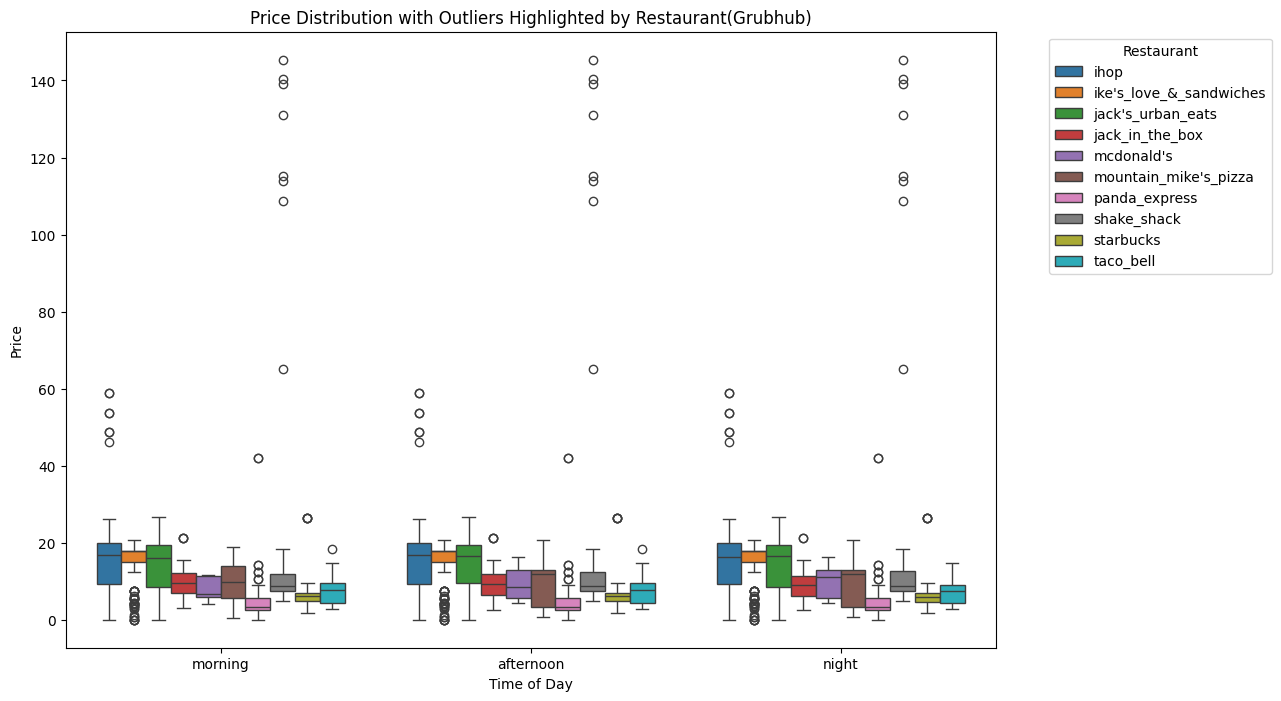

In [ ]:
#Visualization of price distribution with outliers
plt.figure(figsize=(12, 8))
sns.boxplot(x='Time of Day', y='Price', hue='Restaurant', data=cleaned_data, showfliers=True)
plt.title('Price Distribution with Outliers Highlighted by Restaurant(Grubhub)')
plt.legend(title='Restaurant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
import pandas as pd

pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)  
pd.set_option('display.max_colwidth', None)  

#Analyze the frequency of different items
def item_frequency_analysis(df):
    frequency = df.groupby(['Restaurant', 'Item Name', 'Time of Day']).size().unstack(fill_value=0)
    print("Item Frequency Across Times of Day:\n", frequency)

item_frequency_analysis(cleaned_data)

Item Frequency Across Times of Day:
 Time of Day                                                                              afternoon  morning  night
Restaurant              Item Name                                                                                 
ihop                    2 Eggs                                                                   1        1      1
                        2 x 2 x 2                                                                2        2      2
                        55+ 2 x 2 x 2                                                            1        1      1
                        55+ BLT                                                                  1        1      1
                        55+ Breakfast Sampler                                                    1        1      1
                        55+ Crispy Fish                                                          1        1      1
                        55+ Crispy Shrimp  

c:\Python310\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Celine John Philip\AppData\Local\Temp\ipykernel_9840\3807531554.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlation_results = correlation_results.append({
C:\Users\Celine John Philip\AppData\Local\Temp\ipykernel_9840\3807531554.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlation_results = correlation_results.append({
c:\Python310\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Celine John Philip\AppData\Local\Temp\ipykernel_9

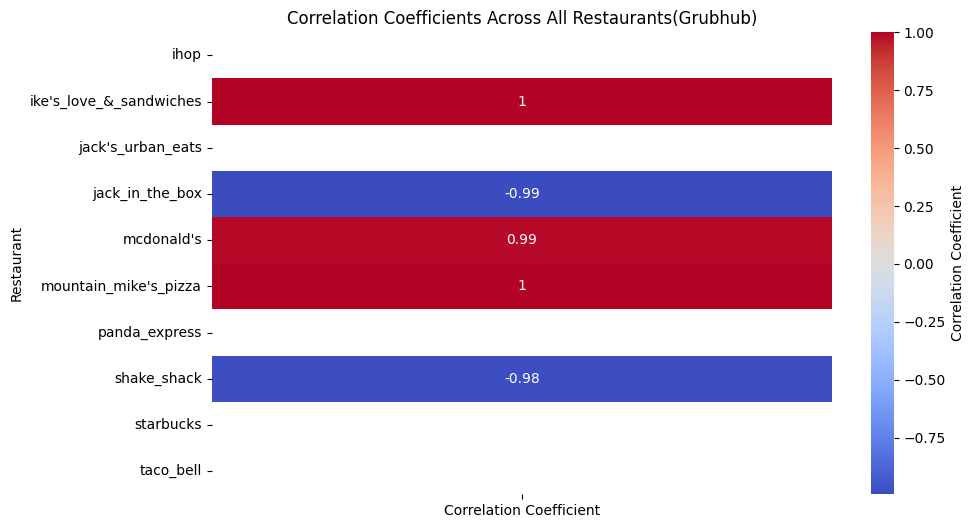

                Restaurant  Correlation Coefficient       P-Value
0                     ihop                      NaN           NaN
1  ike's_love_&_sandwiches                 1.000000  9.486374e-09
2        jack's_urban_eats                      NaN           NaN
3          jack_in_the_box                -0.994500  6.679774e-02
4               mcdonald's                 0.990623  8.725087e-02
5    mountain_mike's_pizza                 1.000000  0.000000e+00
6            panda_express                      NaN           NaN
7              shake_shack                -0.983656  1.152564e-01
8                starbucks                      NaN           NaN
9                taco_bell                      NaN           NaN


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

#Correlation matrix of different restuarants
def consolidated_menu_correlation_analysis(df):
    correlation_results = pd.DataFrame(columns=['Restaurant', 'Correlation Coefficient', 'P-Value'])

    for restaurant in df['Restaurant'].unique():
        df_restaurant = df[df['Restaurant'] == restaurant]
        
        summary = df_restaurant.groupby('Time of Day').agg({'Price': ['mean', 'count']})
        summary.columns = ['Average Price', 'Menu Count']  
        
        if summary.shape[0] > 1:
            corr, p_value = pearsonr(summary['Average Price'], summary['Menu Count'])
            
            correlation_results = correlation_results.append({
                'Restaurant': restaurant,
                'Correlation Coefficient': corr,
                'P-Value': p_value
            }, ignore_index=True)
        else:
            print(f"Not enough data to analyze {restaurant}")

    if not correlation_results.empty:
        plt.figure(figsize=(10, 6))
        sns.heatmap(correlation_results.set_index('Restaurant').drop('P-Value', axis=1), annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
        plt.title('Correlation Coefficients Across All Restaurants(Grubhub)')
        plt.show()

    return correlation_results

all_restaurants_correlation = consolidated_menu_correlation_analysis(cleaned_data)
print(all_restaurants_correlation)
